In [4]:
import numpy as np
import pandas as pd
import import_ipynb
import pair_selection_DBSCAN_funclist_for_training as myFunc
import matplotlib.pyplot as plt

import math
import sklearn
from datetime import datetime

from sklearn import datasets, linear_model
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures
import pickle

import warnings
warnings.filterwarnings('ignore')

In [5]:
def trade_index (trial=-1):
    '''return start_date, end_date'''
    
    monthly = pd.date_range('2009-12-31', '2022-1-1', freq='MS')
    period_candi = [(6,1),(12,7),(24,12)]
    formation_train = {}
    for cnd in period_candi:

        train_window_width = cnd[0]
        test_window_width = cnd[1]

        train_period = []
        test_period = []
        for i in range(len(monthly)- train_window_width-test_window_width):
            train_start_date = monthly[i]
            train_end_date = monthly[i+train_window_width]
            test_end_date = monthly[i+train_window_width+test_window_width]

            if test_end_date.year < 2017:

                train_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
            
            elif test_end_date.year >=2017:

                test_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
                
        formation_train[cnd] = (train_period, test_period)
    # trading 기간 2019-01-01 ~ 2021-12-31
    performance_test = formation_train[(12,7)][1][30:]

    if trial == -1:

        return performance_test[0][1], performance_test[-1][-1]
        
    else:
        return performance_test[trial-1][1], performance_test[trial-1][2]


def plotting_inv_trial (reg_pkl, price_df, trial=1, method='cum', total=False):

    if pd.isnull(reg_pkl[f'trial_{trial}'][0]) == True:
        return print('None')

    else:
        trial_df = pd.DataFrame(reg_pkl[f'trial_{trial}'])

    result_index =  price_df.loc[trade_index(trial)[0]:trade_index(trial)[1]].index.unique()[:trial_df.iloc[0,0].size]
    
    if method == 'cum':

        port = np.zeros((len(result_index), len(trial_df.columns)))

        for idx, pair in enumerate(trial_df.columns):
            port[:, idx] = trial_df[pair][0]

        plt.figure(figsize=(14,6))
        plt.title(f'Cummulative Return of Portfolio Trial {trial}')
        plt.plot(result_index, np.average(port, axis=1), c='b',label=f'Portfolio {str(result_index[0])[2:11]}- {str(result_index[-1])[2:11]}')
        plt.legend()
        plt.show()

    
    return port


def annualized_sharpe (reg_pkl, price_df, trial=1):
    '''Trial의 샤프를 구해준다'''

    trial_df = pd.DataFrame(reg_pkl[f'trial_{trial}'])

    result_index =  price_df.loc[trade_index(trial)[0]:trade_index(trial)[1]].index.unique()[:trial_df.iloc[0,0].size]

    port = np.zeros((len(result_index), len(trial_df.columns)))

    for idx, pair in enumerate(trial_df.columns):
        port[:, idx] = trial_df[pair][0]

    port_path = port.sum(axis=1) / len(trial_df.columns)

    annualized_sharpe= pd.DataFrame(port_path).pct_change().dropna().mean().item() * 252 / (pd.DataFrame(port_path).pct_change().dropna().std().item() * np.sqrt(252))

    return annualized_sharpe, port_path

def annualized_sharpe_total (reg_pkl, price_df, with_nan='No'):
    
    tmp = np.zeros((122, 35))
    count = 0
    for idx in range(1,len(reg_pkl)+1):
        
        sharpe, port_path = annualized_sharpe(reg_pkl, price_df, idx)

        if pd.isnull(sharpe) is True:
            pass
        else:
            tmp[:,count] = port_path[:122]
            count += 1
        #tmp = pd.concat([tmp, list(port_path)], ignore_index=True)

    all_path = tmp[:,:count]

    cov_df = pd.DataFrame(all_path).pct_change().dropna().cov()
    all_mean = pd.DataFrame(all_path).pct_change().dropna().mean().mean() * 252

    nan_count = 0
    count = 0
    for x in range(1, 32):
        check = annualized_sharpe(reg_pkl, price_df, x)[0]
        if pd.isnull(check) is True:
            nan_count += 1
        else:
            count += 1

    if with_nan =='No':
        all_std = np.sqrt(cov_df.sum().sum()/count**2) * np.sqrt(252)
        sharpe = all_mean / all_std
    else:
        all_std = np.sqrt(cov_df.sum().sum() / (count+nan_count)**2) * np.sqrt(252)
        sharpe = all_mean/all_std

    return sharpe

def individual_pairs_return (result, price_df, trial=1):    
    
    trial_df = pd.DataFrame(result[f'trial_{trial}'])
    result_index =  price_df.loc[trade_index(2)[0]:trade_index(2)[1]].index.unique()[:trial_df.iloc[0,0].size]

    trial_columns = list(pd.DataFrame(result[f'trial_{trial}']).columns)

    for idx, x in enumerate(trial_columns):
        pair = trial_columns[idx]

        pair_path = trial_df[pair][0][0]
        pair_rtn = (pair_path[-1] - pair_path[0])/pair_path[0]
        annu_pair_rtn = 2 * pair_rtn

        plt.figure(figsize=(14,6))
        plt.plot(result_index, pair_path, label=f"{pair}'s Path")
        plt.legend()
        plt.show()

        print(f"{pair}'s annualized return = {annu_pair_rtn}")

def individual_trial_return (reg_pkl, price_df, trial=1, print_opt=1):

    if pd.isnull(reg_pkl[f'trial_{trial}'][0]) == True and print_opt == 1:
        return print('None')
    
    elif pd.isnull(reg_pkl[f'trial_{trial}'][0]) == True and print_opt != 1:
        return

    else:
        trial_df = pd.DataFrame(reg_pkl[f'trial_{trial}'])

    result_index =  price_df.loc[trade_index(trial)[0]:trade_index(trial)[1]].index.unique()[:trial_df.iloc[0,0].size]

    port = np.zeros((len(result_index), len(trial_df.columns)))

    for idx, pair in enumerate(trial_df.columns):
        port[:, idx] = trial_df[pair][0]
    
    mean_path = port.sum(axis=1) / port.shape[1]
    ann_path_return = 2 * (mean_path[-1] - mean_path[0])/mean_path[0]
    
    if print == 1:
        print(f"Trial {trial}'s annualized return = {ann_path_return}")
    else:
        pass

    return ann_path_return

def total_trial_return (reg_pkl, price_df):

    test = []
    for x in range(1, len(reg_pkl)+1):
        a = individual_trial_return(reg_pkl, price_df, trial=x, print_opt=0)
        if a == None:
            pass
        else:
            test.append(a)

    total_return = np.array(test).sum() / len(test) 

    return total_return

def mdd (reg_pkl, price_df, trial=2, print_opt=1):

    if pd.isnull(reg_pkl[f'trial_{trial}'][0]) == True and print_opt == 1:
        return print('None')
    
    elif pd.isnull(reg_pkl[f'trial_{trial}'][0]) == True and print_opt != 1:
        return

    else:
        trial_df = pd.DataFrame(reg_pkl[f'trial_{trial}'])

    result_index =  price_df.loc[trade_index(trial)[0]:trade_index(trial)[1]].index.unique()[:trial_df.iloc[0,0].size]

    port = np.zeros((len(result_index), len(trial_df.columns)))

    for idx, pair in enumerate(trial_df.columns):
        port[:, idx] = trial_df[pair][0]
    
    mean_path = port.sum(axis=1) / port.shape[1]

    
    ex_high = pd.Series(mean_path).cummax()
    mdd_path = -(1 - mean_path/ex_high).to_numpy()
    trial_mdd = min(mdd_path)

    return trial_mdd, mdd_path

In [6]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'], index_col=0)
with open('result_may_final_all.pkl','rb') as f:
    result = pickle.load(f)

# 개별 Trial 별 Port path 그리기

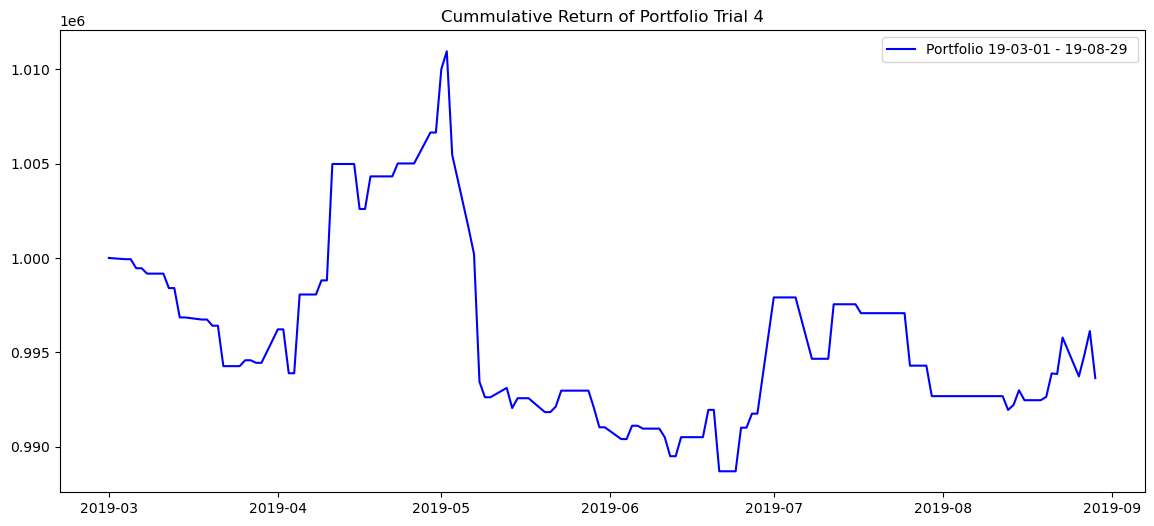

array([[1000000.        , 1000000.        , 1000000.        ,
        1000000.        ],
       [ 999748.69319153, 1000000.        , 1000000.        ,
        1000000.        ],
       [ 999748.69319153, 1000000.        , 1000000.        ,
        1000000.        ],
       [ 997830.04936218, 1000000.        , 1000000.        ,
        1000000.        ],
       [ 997830.04936218, 1000000.        , 1000000.        ,
        1000000.        ],
       [ 996685.59596252, 1000000.        , 1000000.        ,
        1000000.        ],
       [ 996685.59596252, 1000000.        , 1000000.        ,
        1000000.        ],
       [ 993623.5120697 , 1000000.        , 1000000.        ,
        1000000.        ],
       [ 993623.5120697 , 1000000.        , 1000000.        ,
        1000000.        ],
       [ 987403.57540894, 1000000.        , 1000000.        ,
        1000000.        ],
       [ 987403.57540894, 1000000.        , 1000000.        ,
        1000000.        ],
       [ 986961.95178

In [7]:
'''저장되는 값은 path '''

path = plotting_inv_trial(result, price_df, trial=4, method='cum')
path

# 총 포트폴리오의 연율화 샤프

In [8]:
a = annualized_sharpe_total(result, price_df, 'No')
a

2.0057024481729453

# ROI

### 각 Trial 별로 전체 리턴

None
None


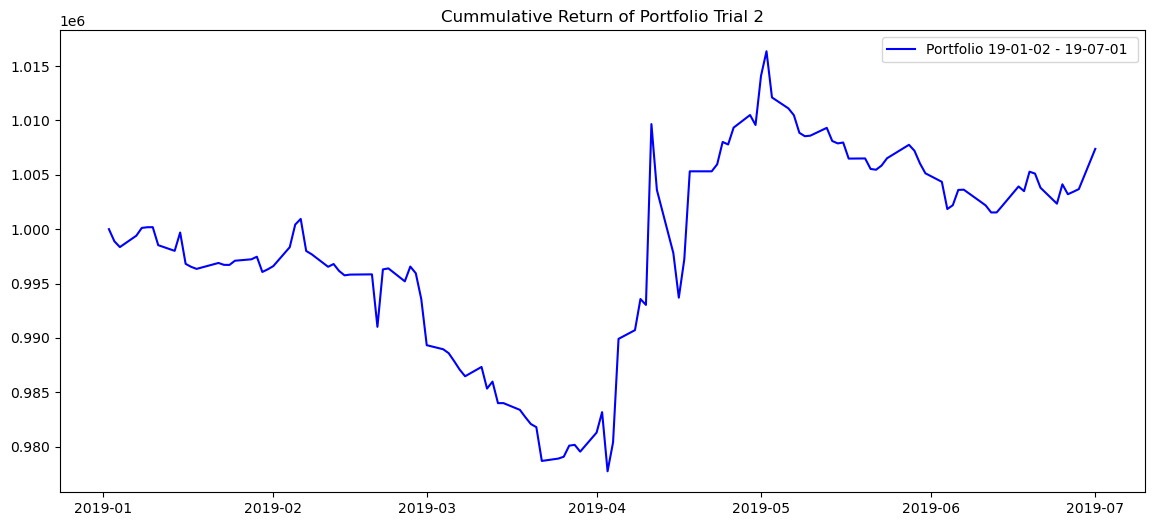

None
None


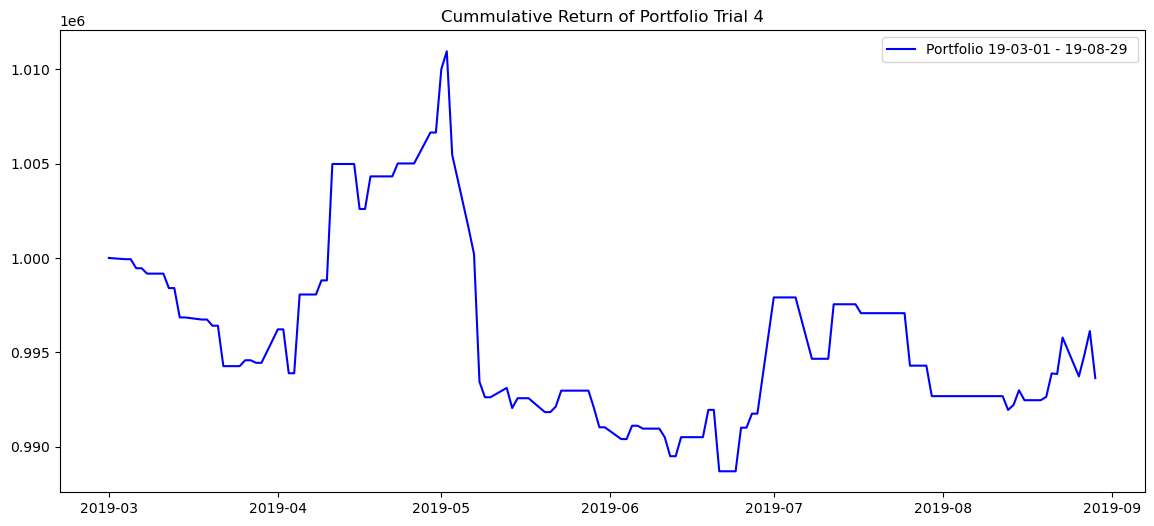

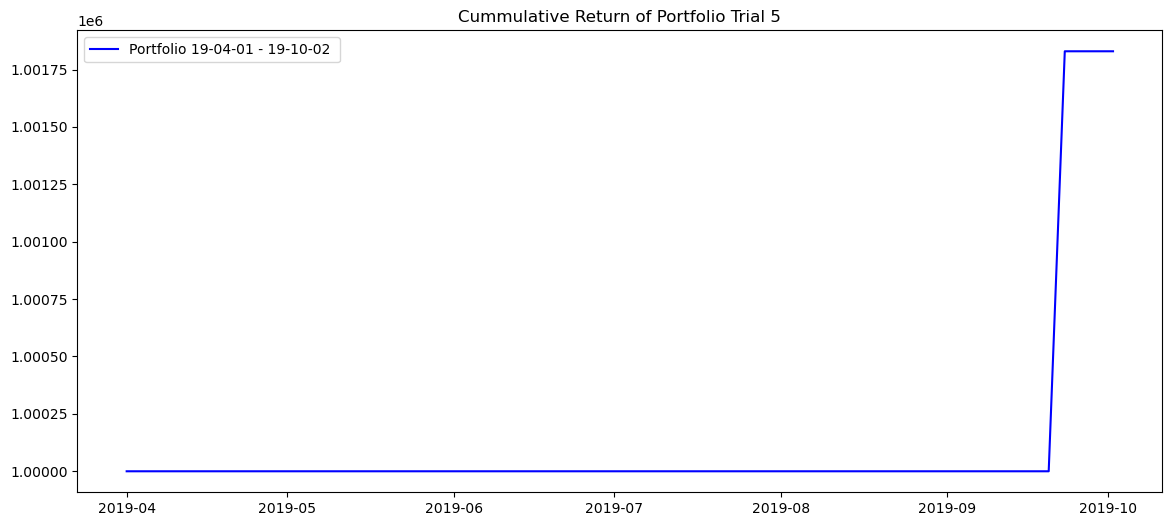

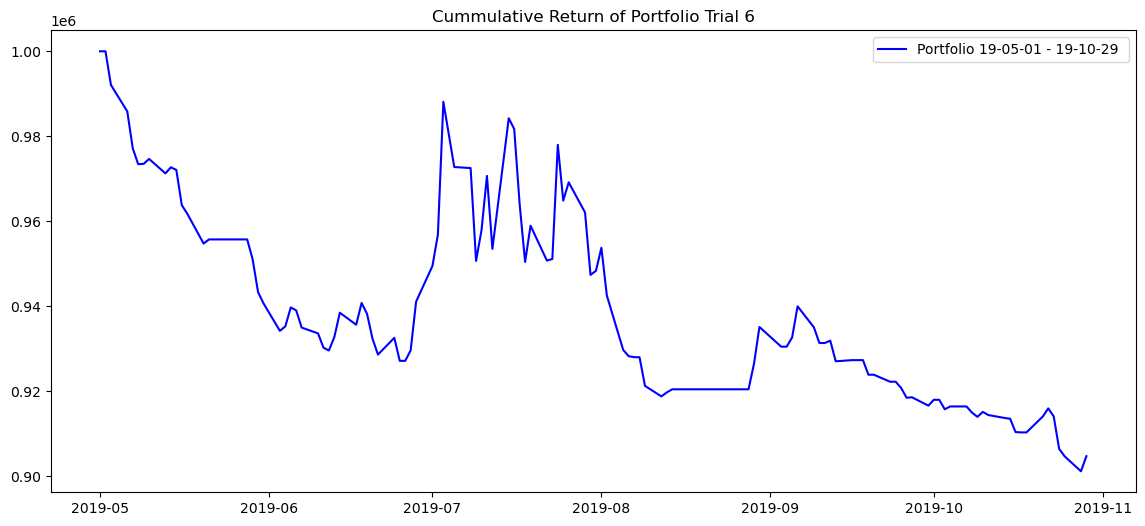

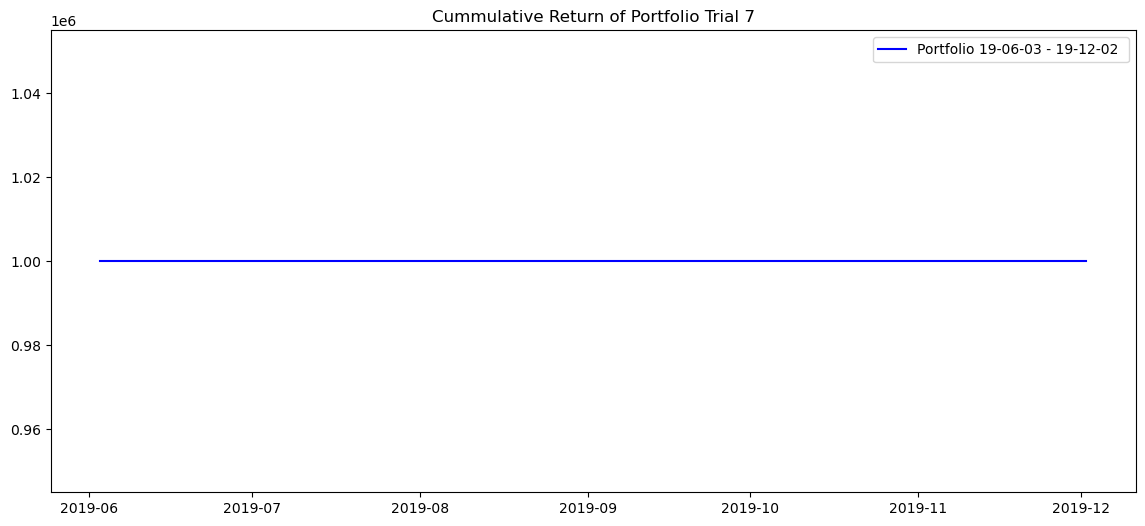

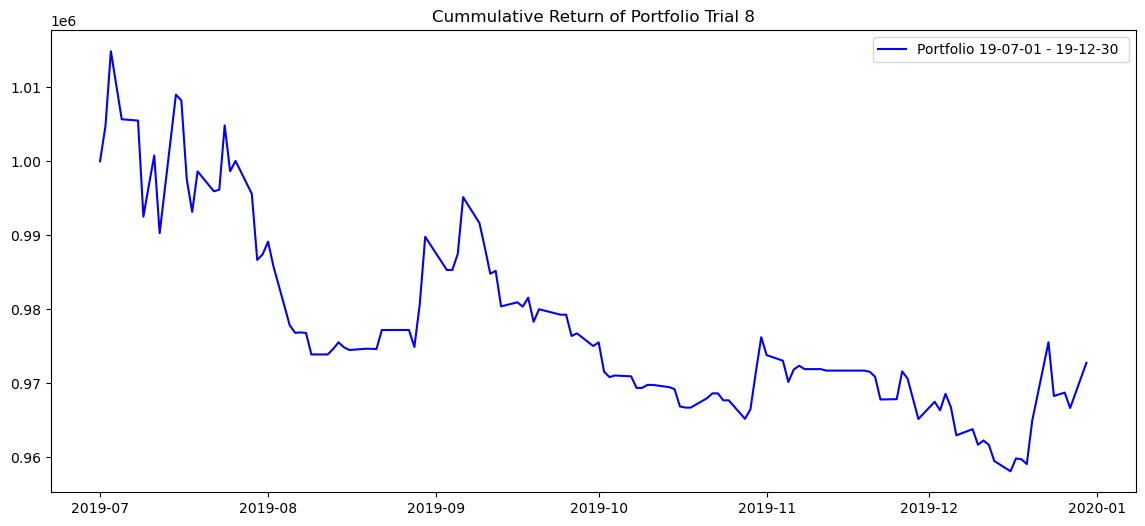

None
None
None
None
None
None
None
None


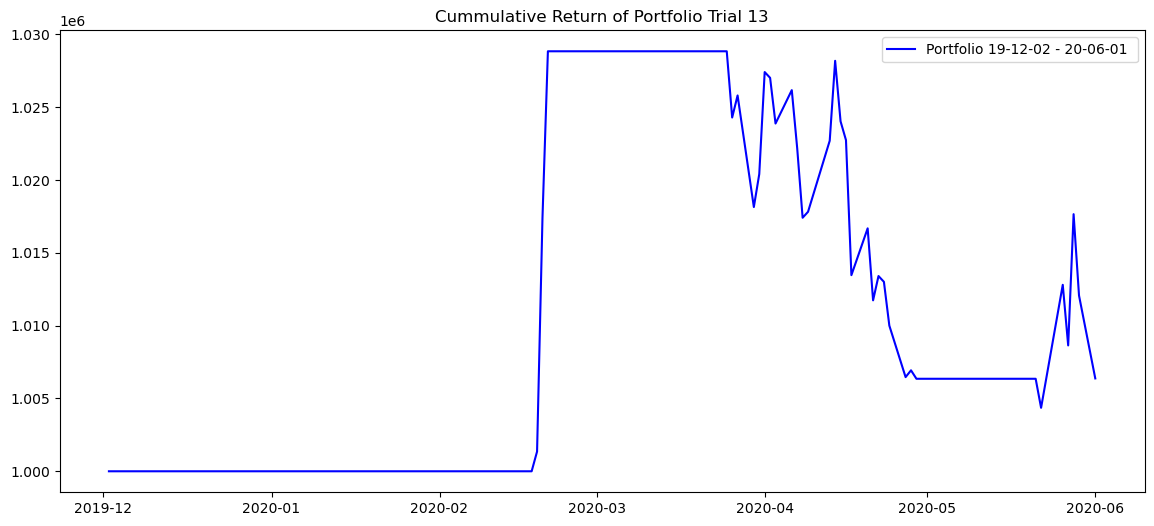

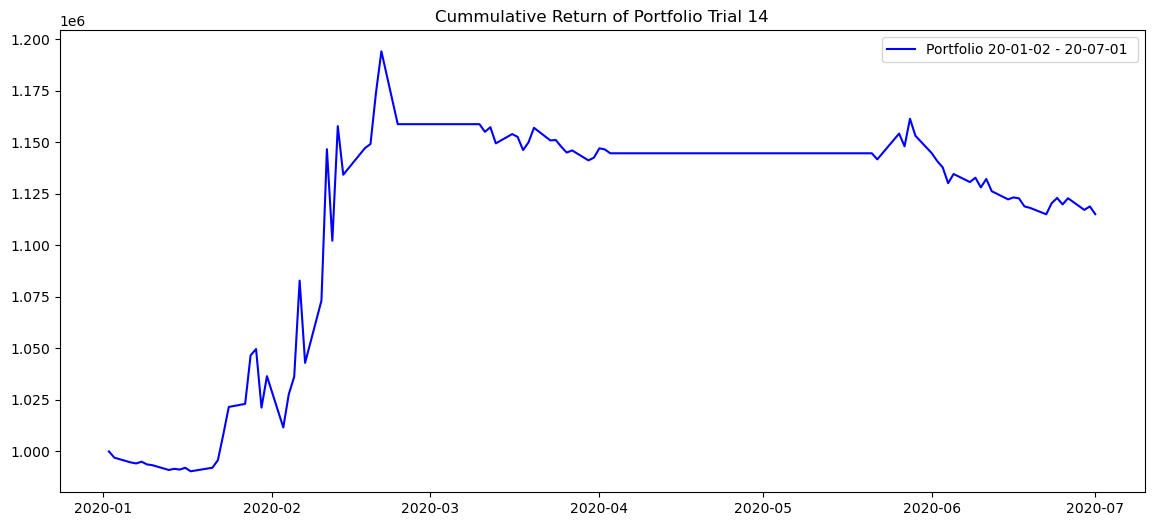

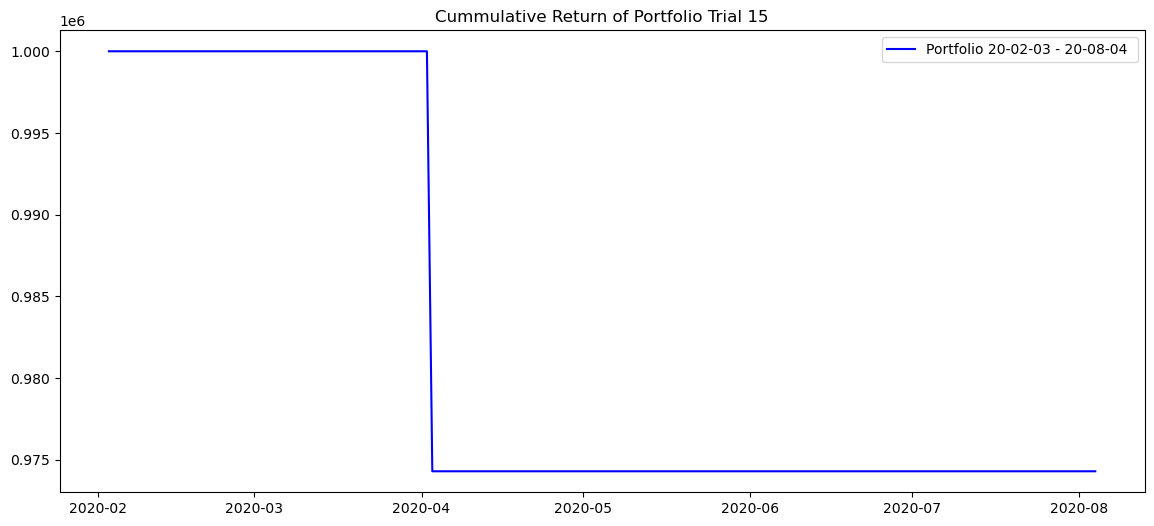

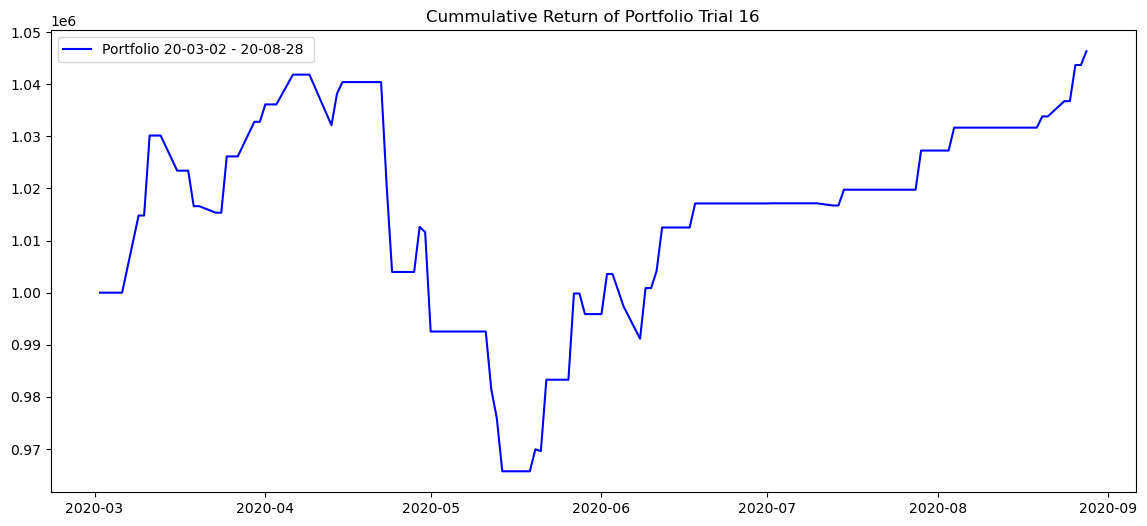

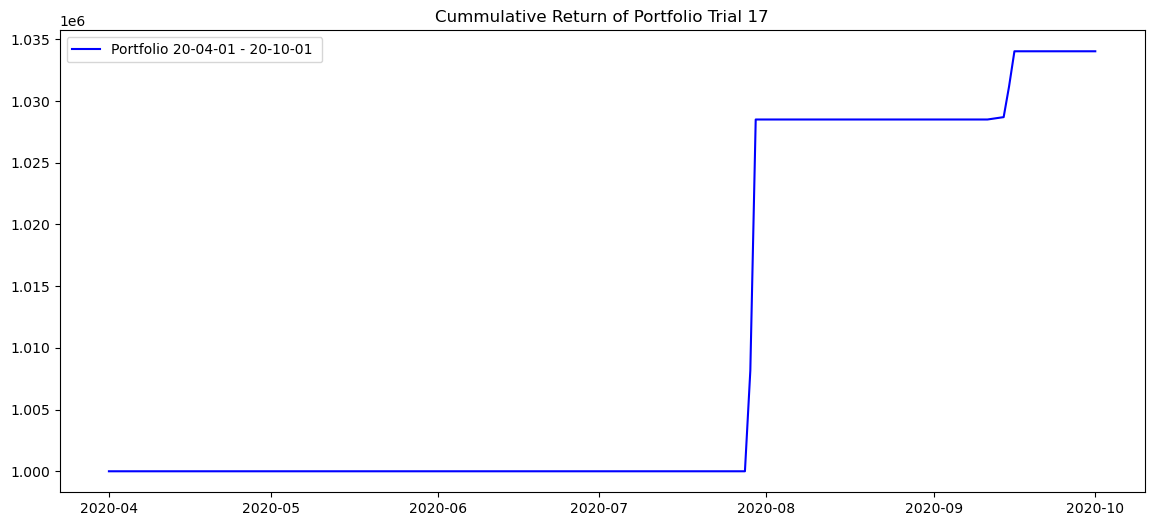

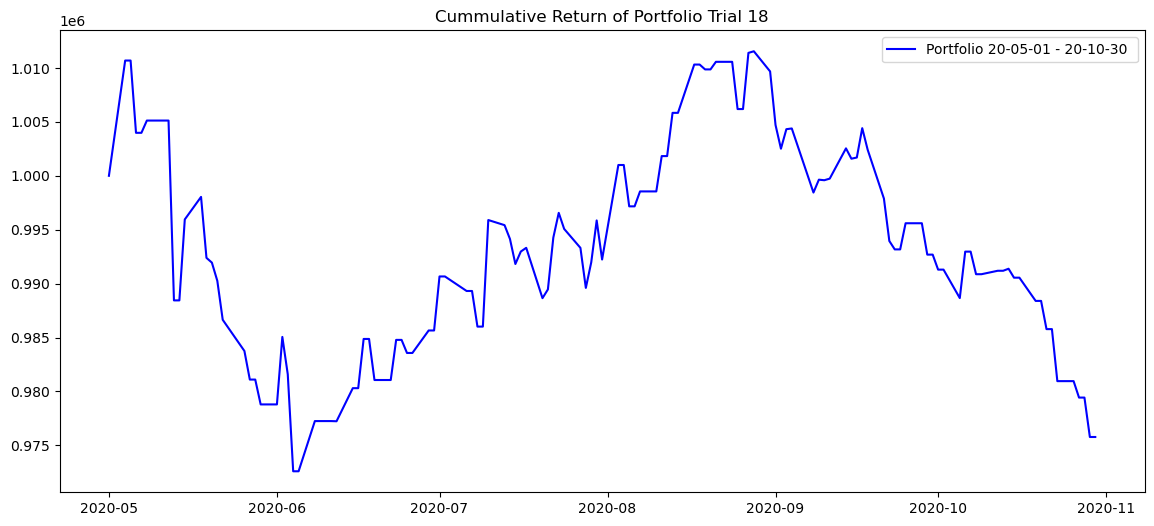

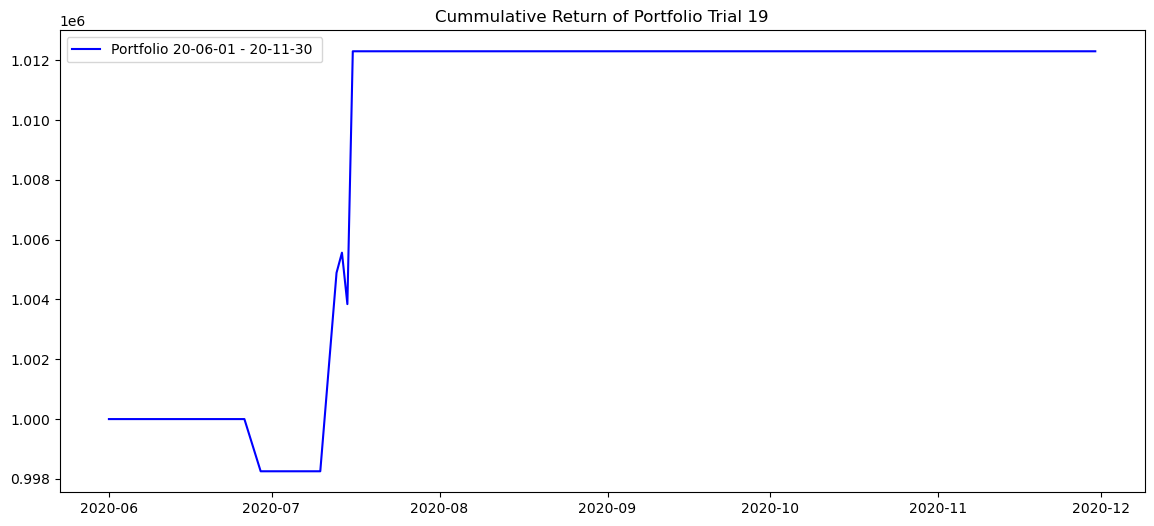

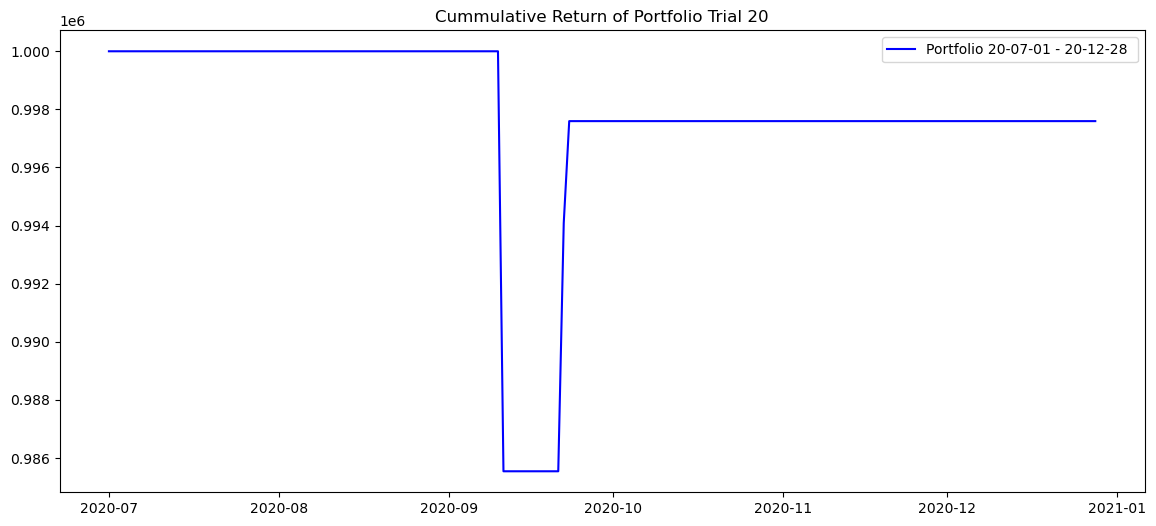

None
None
None
None
None
None
None
None


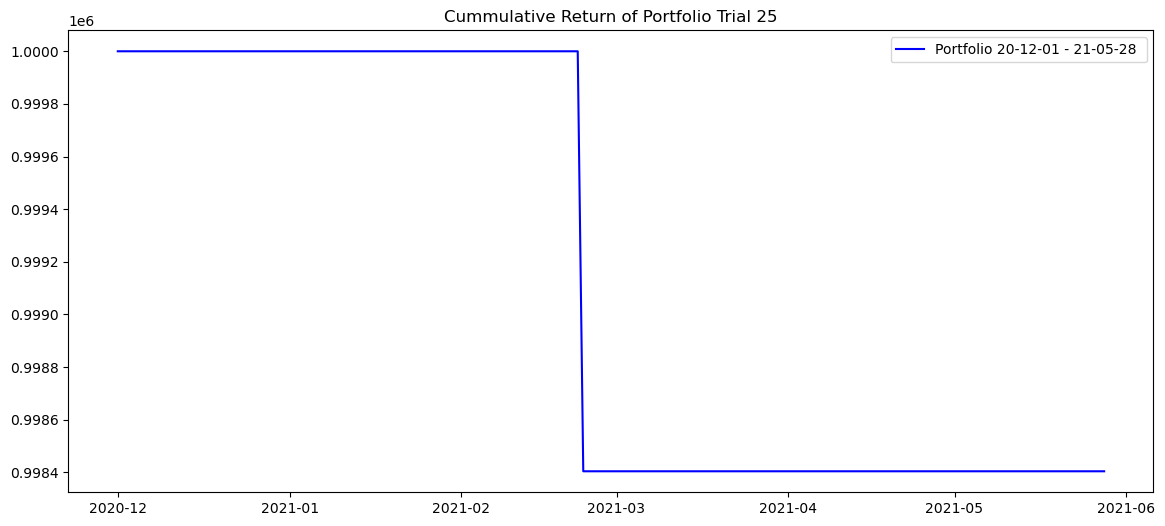

None
None


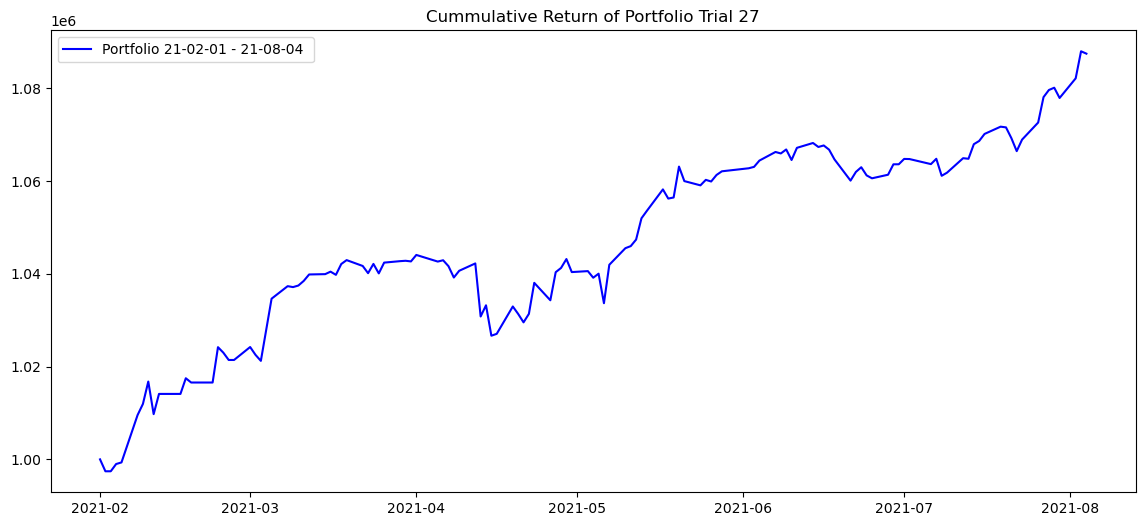

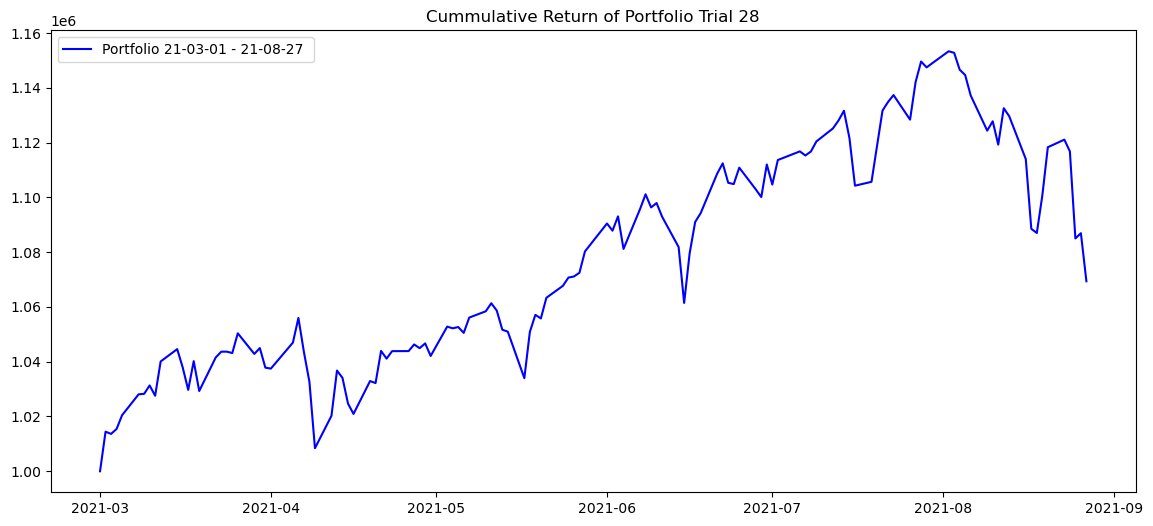

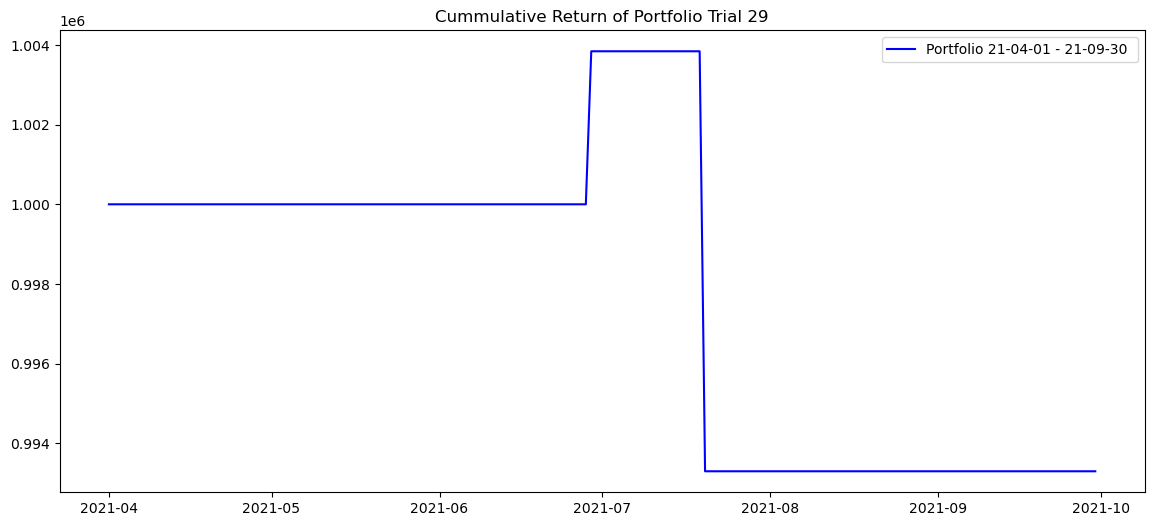

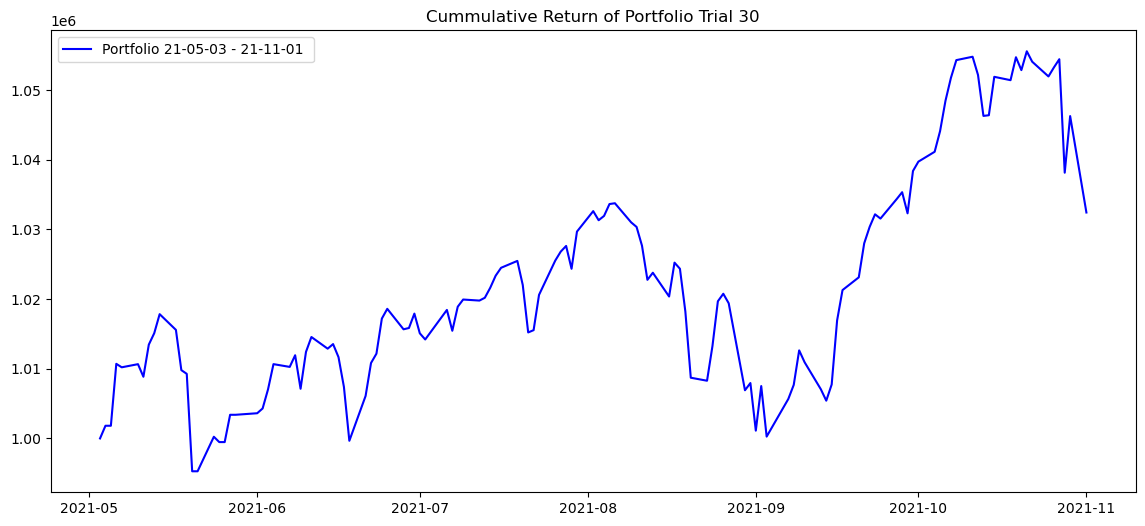

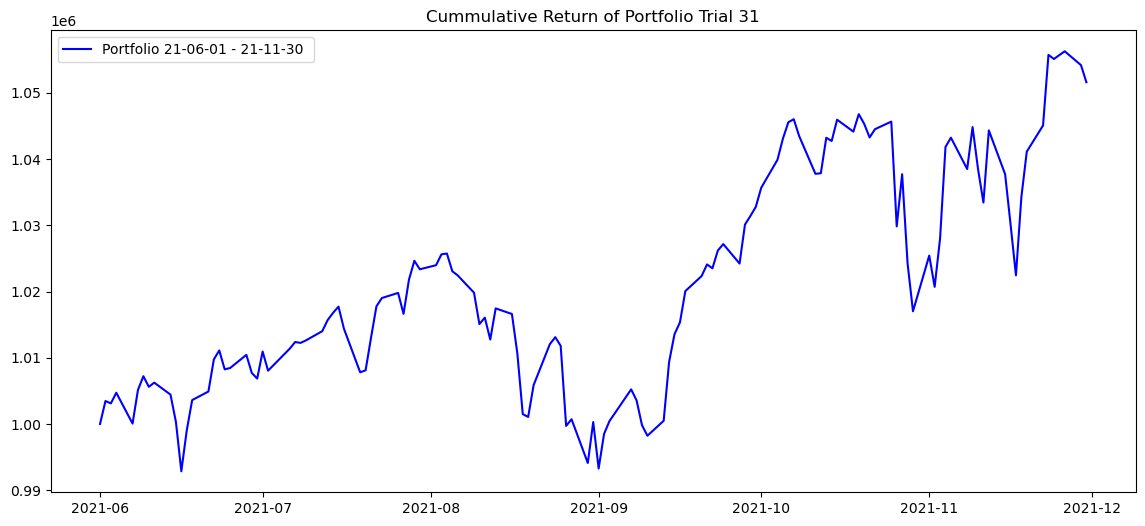

In [14]:
for x in range(1, 32):
    individual_trial_return(result, price_df, x)
    '''이건 그래프 개많이 나옴'''
    plotting_inv_trial(result, price_df, x)

## Trial 안에서 페어별로 

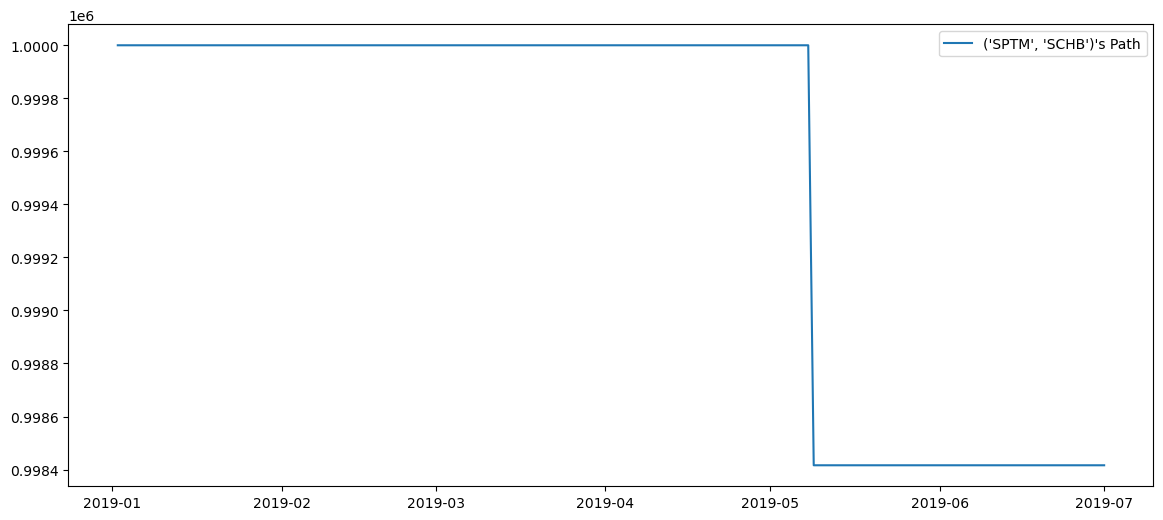

('SPTM', 'SCHB')'s annualized return = -0.0031676819763183594


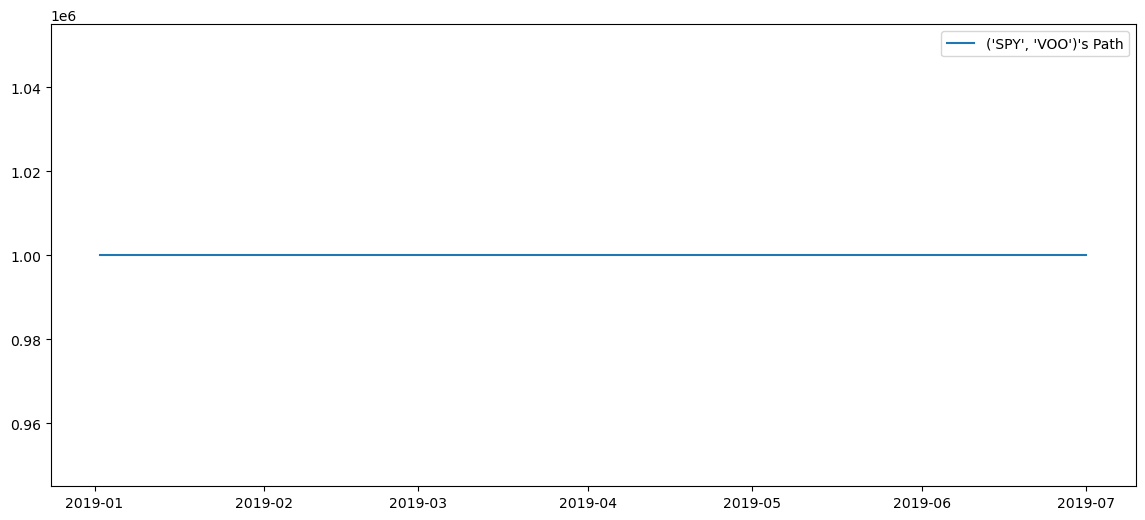

('SPY', 'VOO')'s annualized return = 0.0


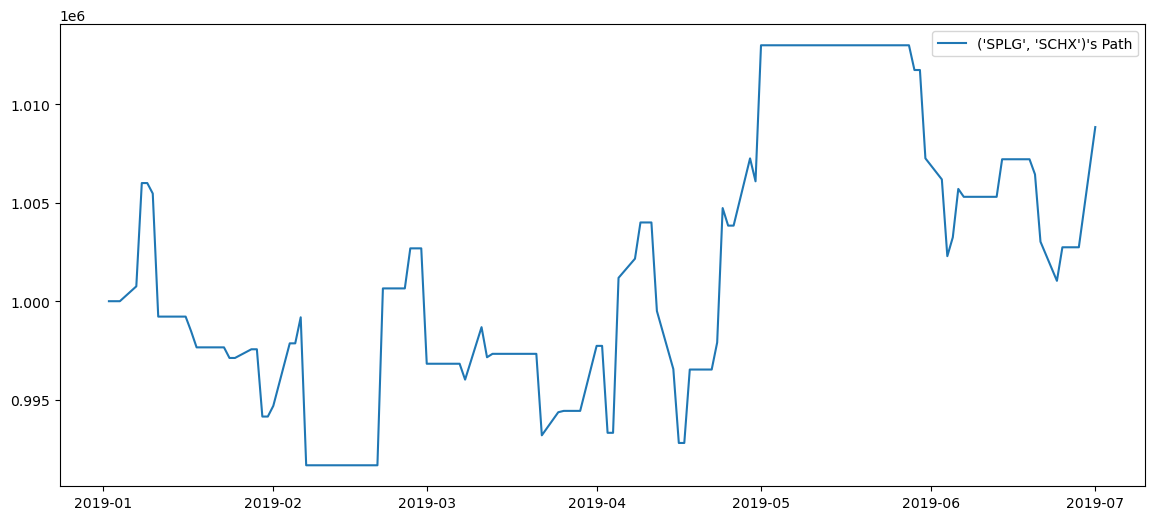

('SPLG', 'SCHX')'s annualized return = 0.01768440185546875


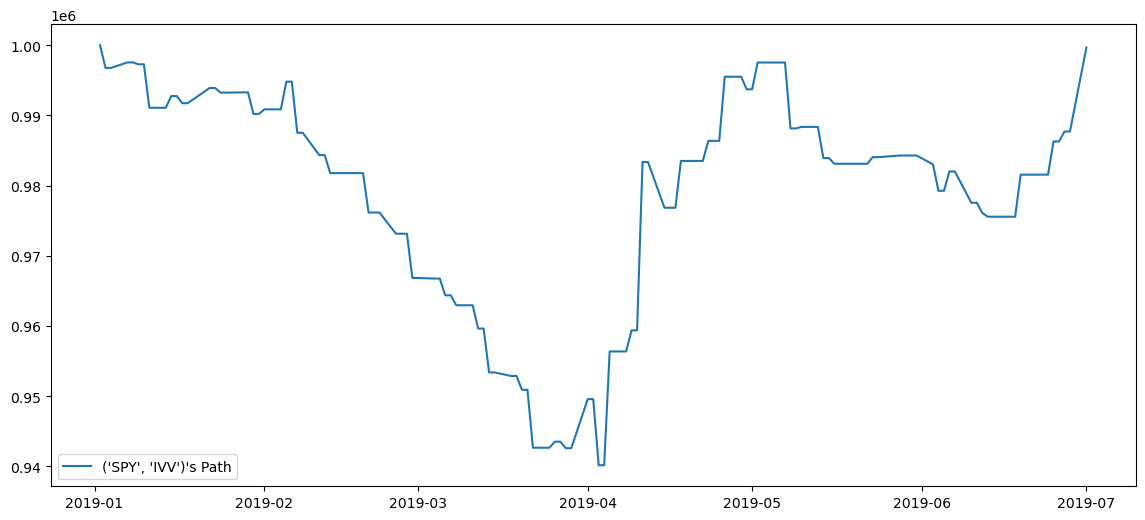

('SPY', 'IVV')'s annualized return = -0.0006264934387211688


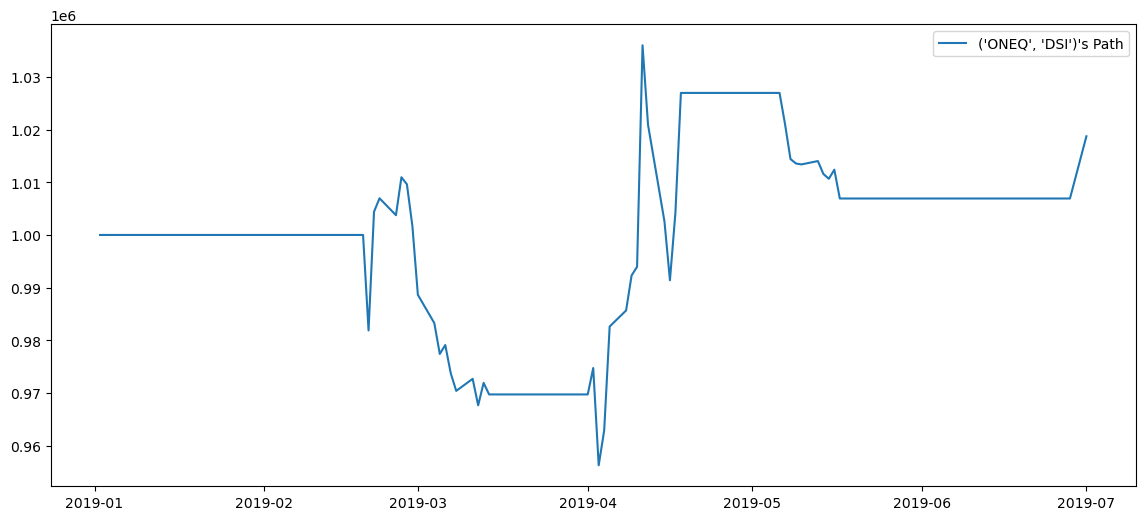

('ONEQ', 'DSI')'s annualized return = 0.03744569382476807


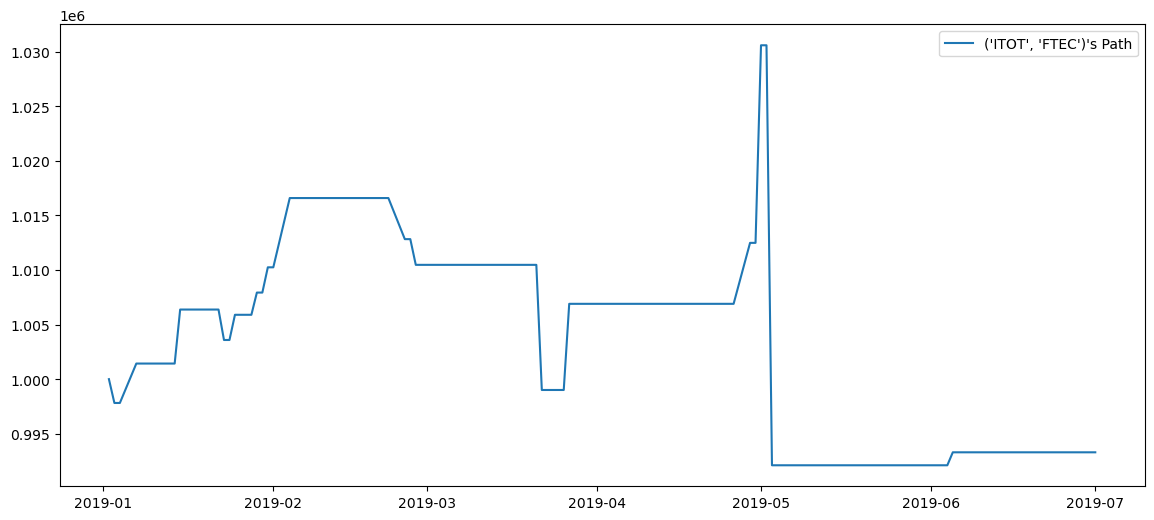

('ITOT', 'FTEC')'s annualized return = -0.013404087280273437


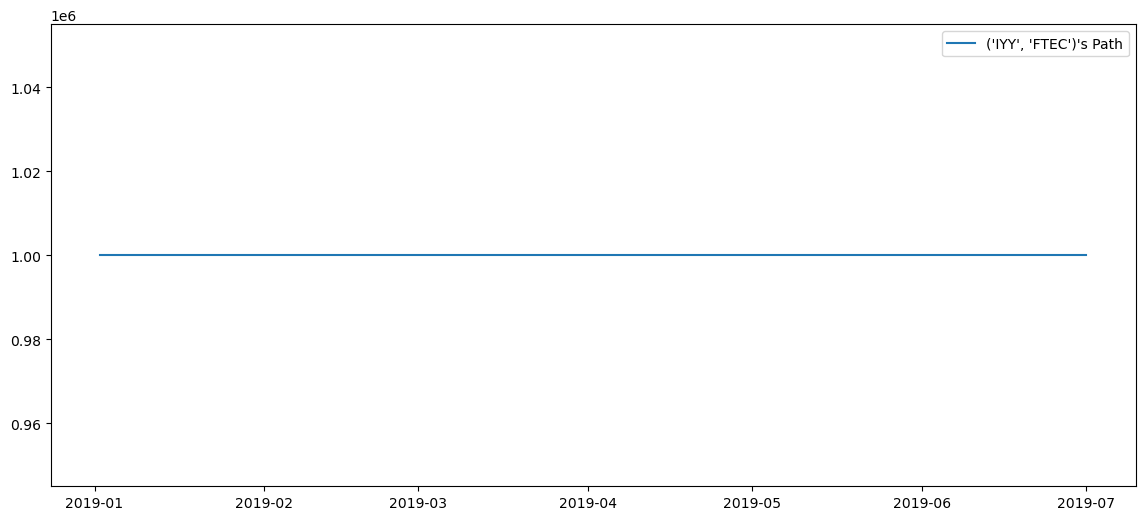

('IYY', 'FTEC')'s annualized return = 0.0


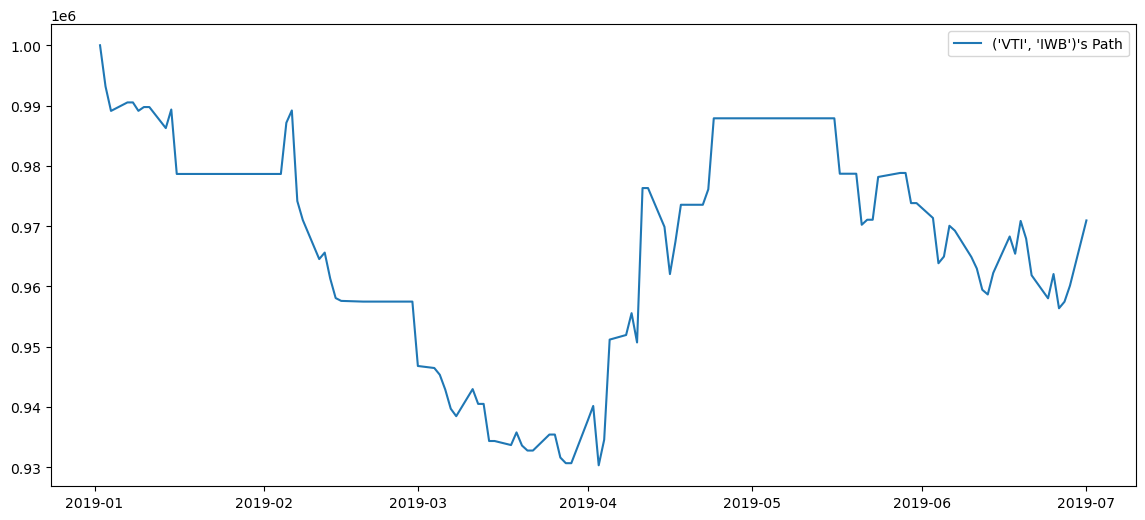

('VTI', 'IWB')'s annualized return = -0.05810781735229492


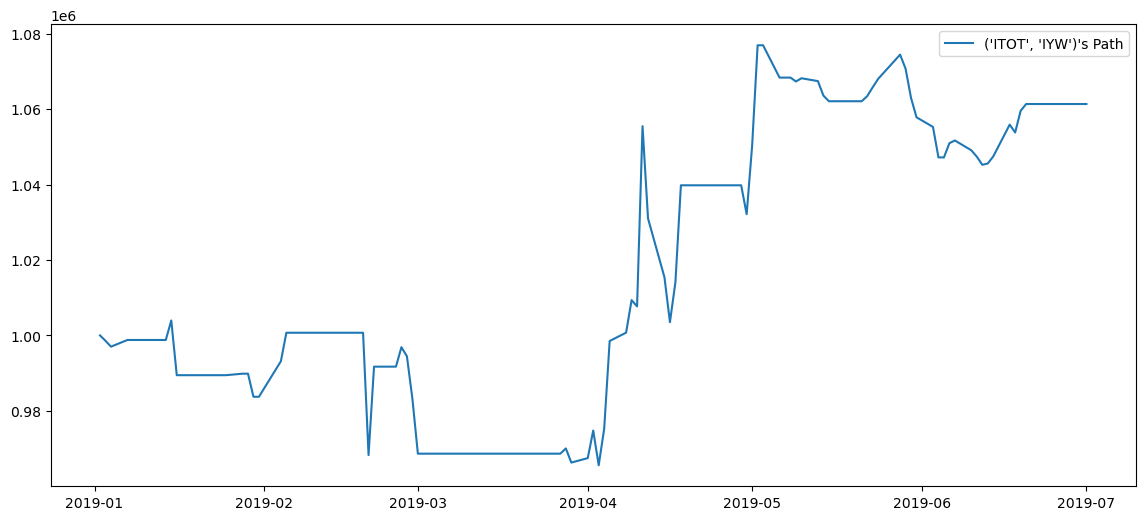

('ITOT', 'IYW')'s annualized return = 0.1226652653427124


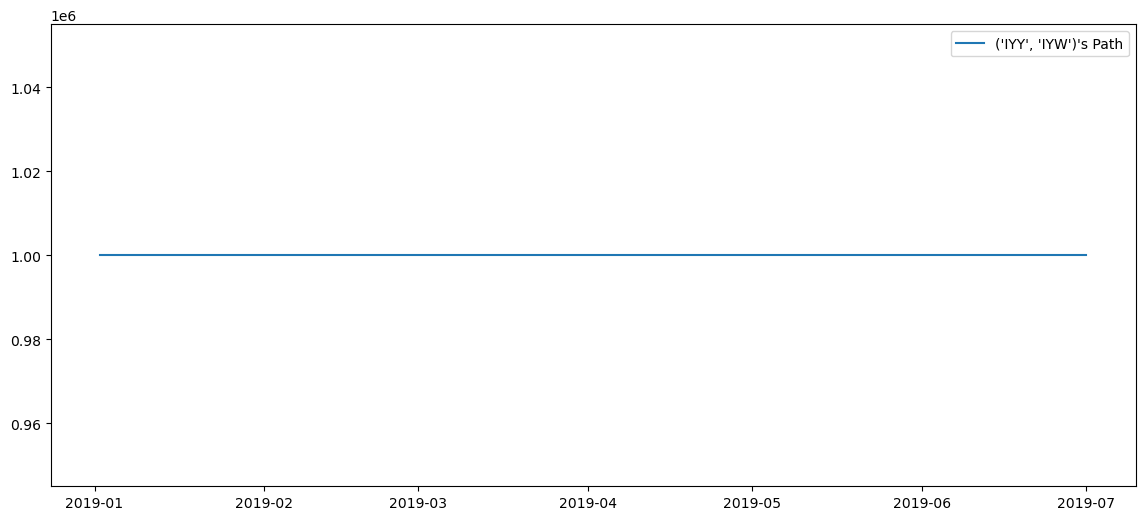

('IYY', 'IYW')'s annualized return = 0.0


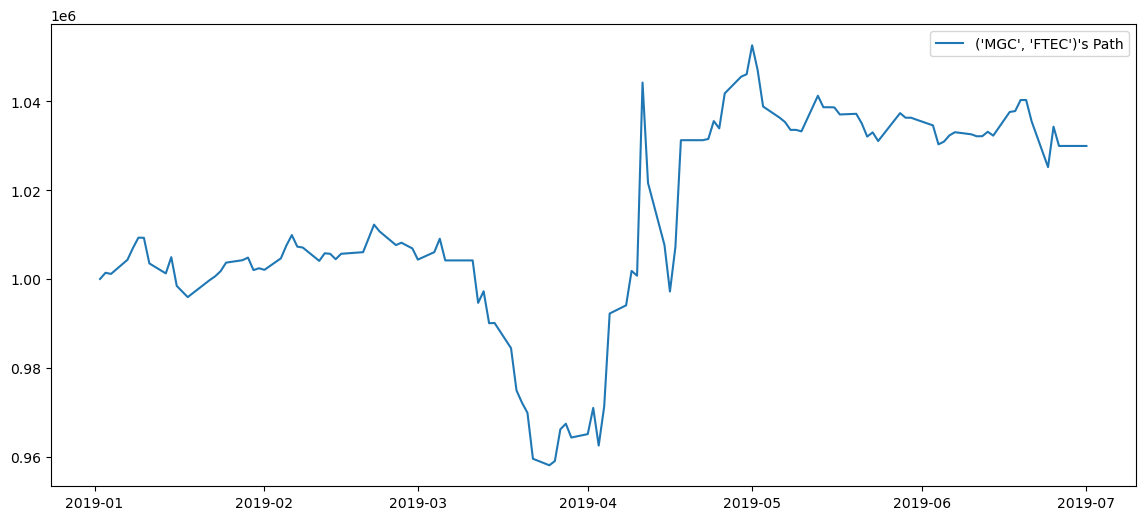

('MGC', 'FTEC')'s annualized return = 0.05994446415710449


In [10]:
individual_pairs_return(result, price_df, trial=2)

## 개별 pair return

In [22]:
tmp = []
for x in range (1, 32):
    tmp.append(individual_trial_return(result, price_df, trial=x))

tmp

None
None
None
None
None
None
None
None
None
None
None


[None,
 0.014766704102949705,
 None,
 -0.012721328475951683,
 0.0036589222106933592,
 -0.19060990098571778,
 0.0,
 -0.054433035680135015,
 None,
 None,
 None,
 None,
 0.012752056414286374,
 0.23016743304138165,
 -0.051408523921966785,
 0.09261767304229736,
 0.06805112119674729,
 -0.048438208183288575,
 0.024595743998209713,
 -0.004808823020935059,
 None,
 None,
 None,
 None,
 -0.0031925851364135744,
 None,
 0.17503279799397756,
 0.13873617700195312,
 -0.013405552310943604,
 0.06486911510658264,
 0.10319203957366943]

## 전체 포트폴리오의 최종 연환산 수익률

In [11]:
total_trial_return(result, price_df) 

0.027471091298369804

## MDD (with path)

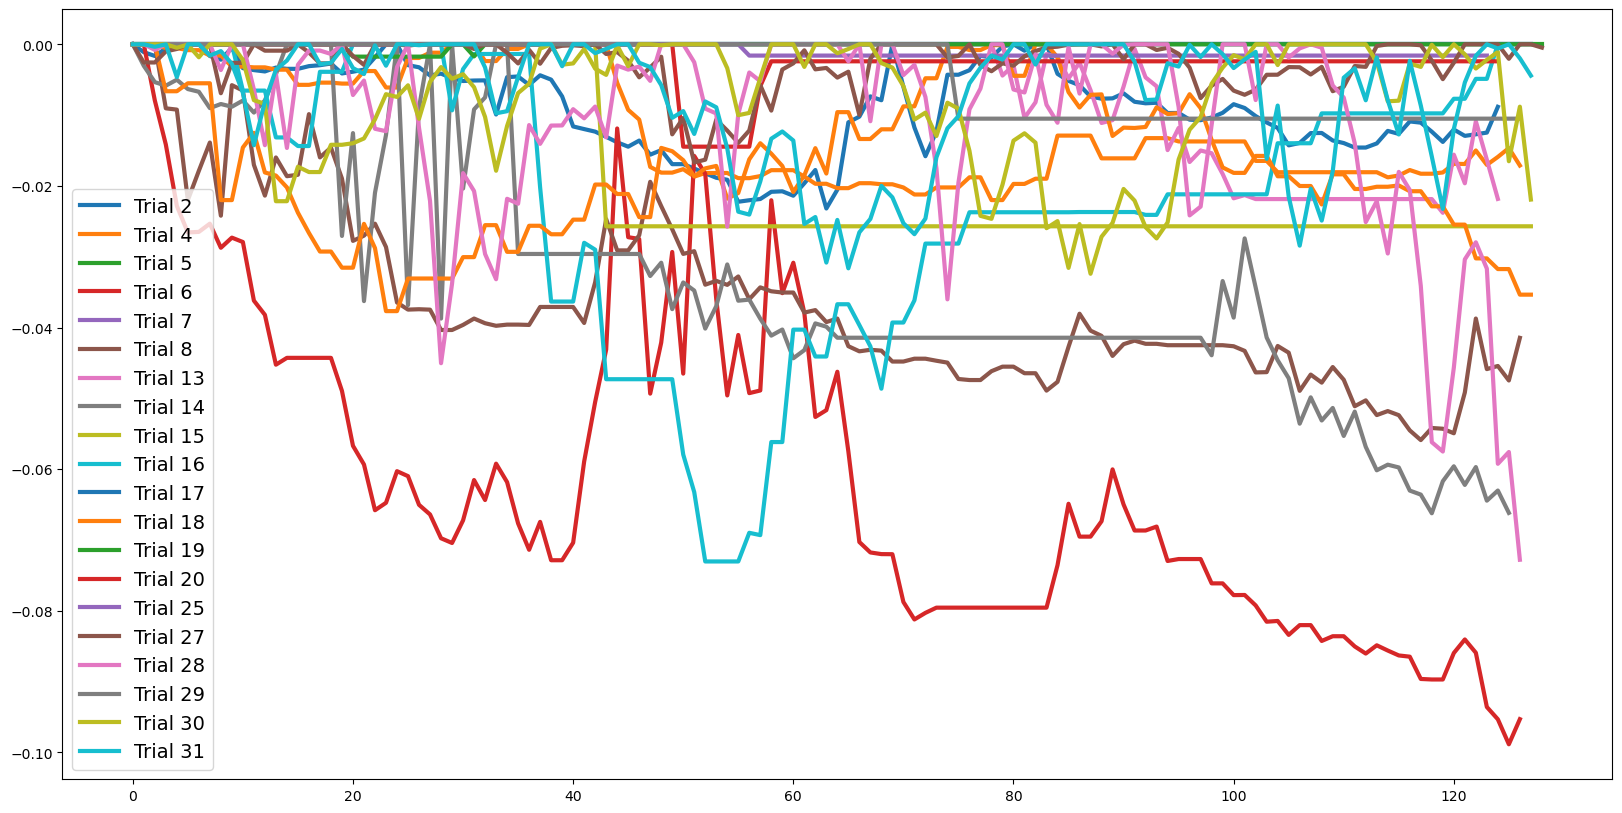

In [12]:
plt.figure(figsize=(20,10))
for x in range(1, 32):
    try:
        plt.plot(mdd(result, price_df, x, 2)[1], linewidth=3, label=f'Trial {x}')
    except:
        pass
plt.legend(fontsize=14)
plt.show()

## Cumulative Return 개별 자산

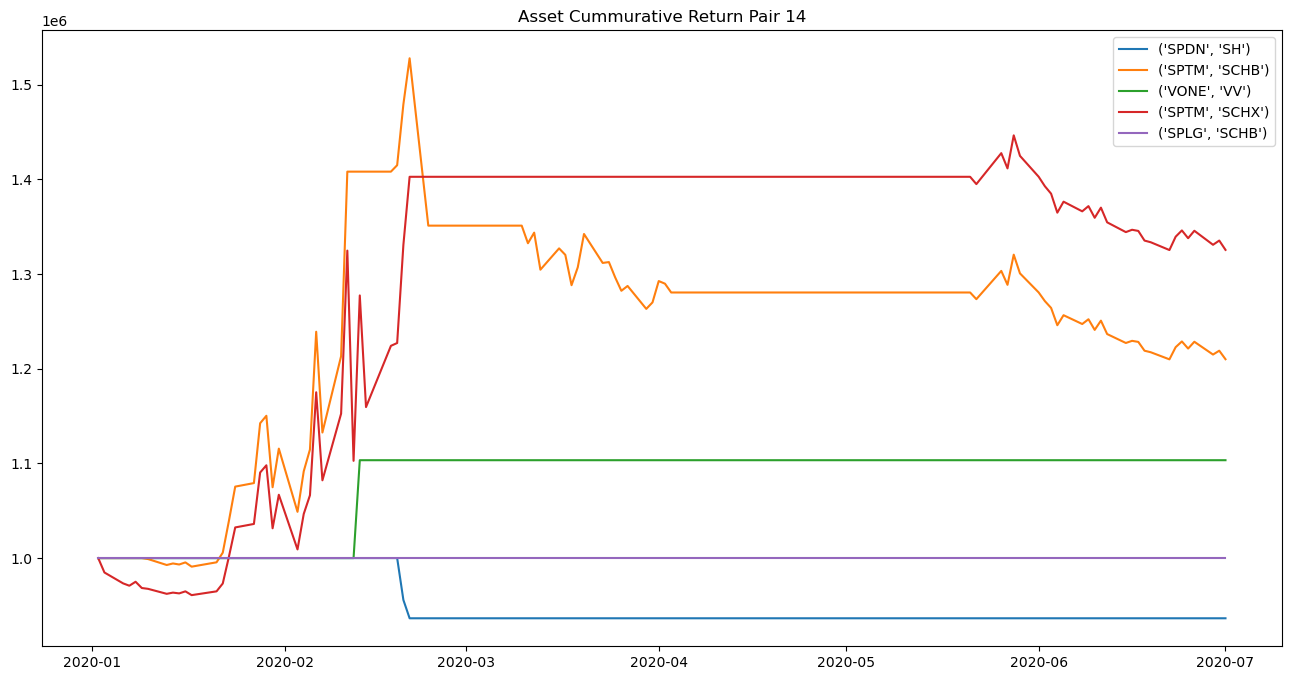

In [29]:
trial_df = pd.DataFrame(result['trial_14'])

result_index =  price_df.loc[trade_index(14)[0]:trade_index(14)[1]].index.unique()[:trial_df.iloc[0,0].size]

plt.figure(figsize=(16,8))
plt.title('Asset Cummurative Return Pair 14')

for x in list(trial_df.columns):
    plt.plot(result_index, trial_df[x][1].reshape(-1,1), label=f'{x}')
    
plt.legend()
plt.show()

## 동일가중 포트폴리오의 전체 수익률

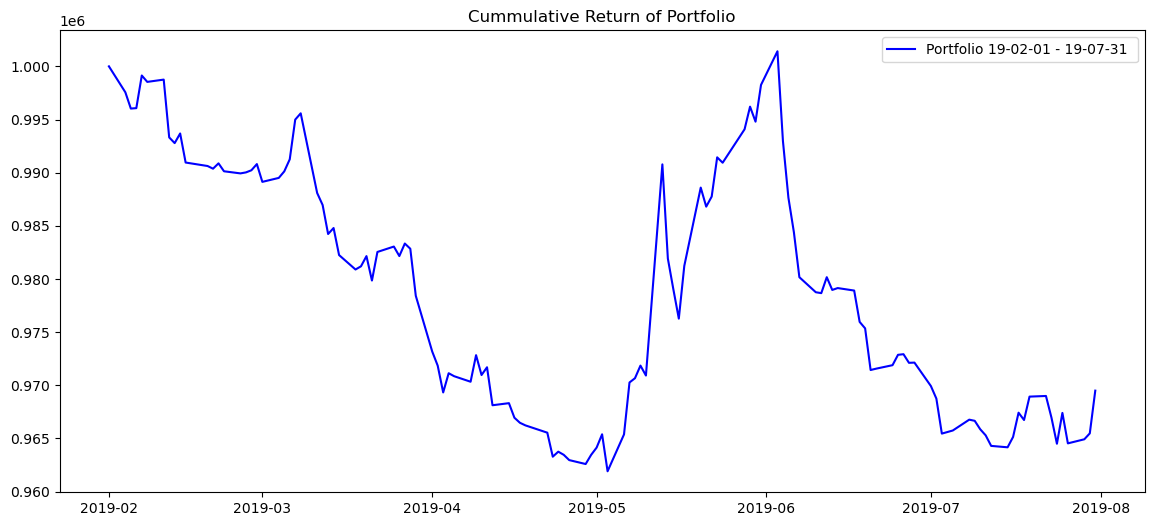

In [ ]:
port = np.zeros((len(result_index), len(trial_df.columns)))

for idx, pair in enumerate(trial_df.columns):
    port[:, idx] = trial_df[pair][0]

plt.figure(figsize=(14,6))
plt.title('Cummulative Return of Portfolio')
plt.plot(result_index, np.average(port, axis=1), c='b',label=f'Portfolio {str(result_index[0])[2:11]}- {str(result_index[-1])[2:11]}')
plt.legend()
plt.show()

## Trial 14에 대한 전체 포트폴리오 

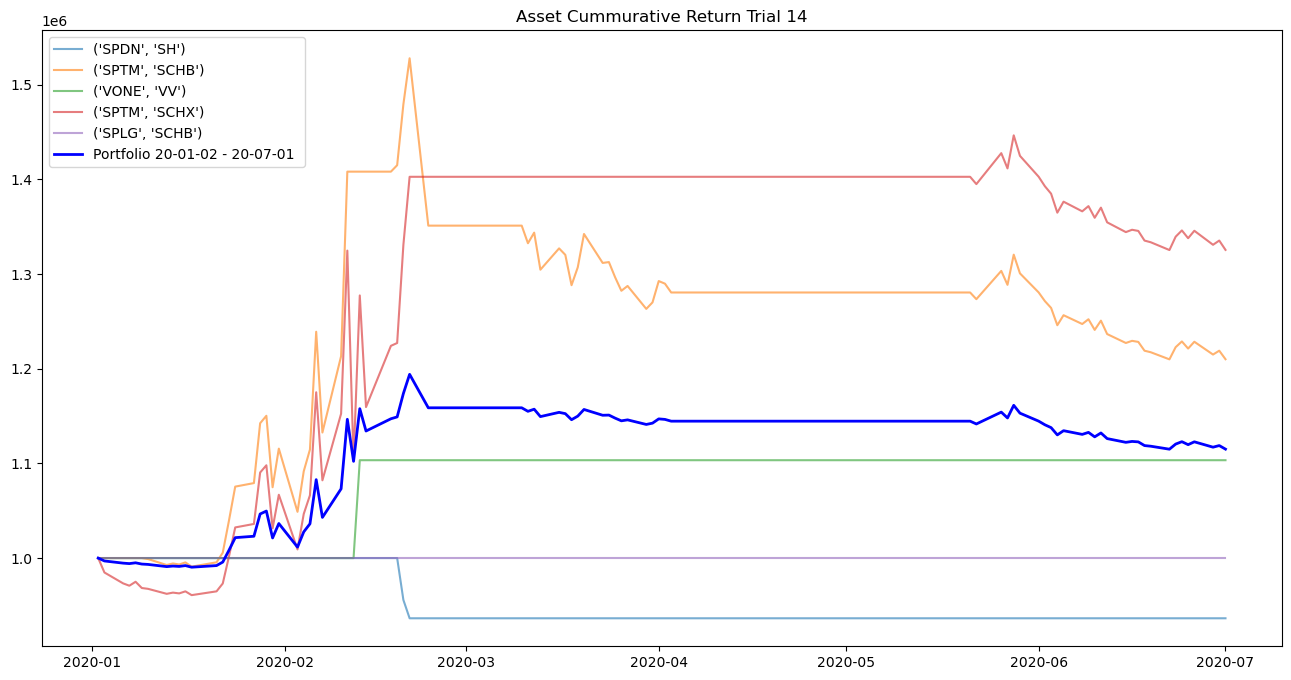

In [34]:
trial_df = pd.DataFrame(result['trial_14'])

result_index =  price_df.loc[trade_index(14)[0]:trade_index(14)[1]].index.unique()[:trial_df.iloc[0,0].size]

plt.figure(figsize=(16,8))
plt.title('Asset Cummurative Return Trial 14')

port = np.zeros((len(result_index), len(trial_df.columns)))

for idx, pair in enumerate(trial_df.columns):
    port[:, idx] = trial_df[pair][0]

for x in list(trial_df.columns):
    plt.plot(result_index, trial_df[x][1].reshape(-1,1), alpha=0.6,label=f'{x}')
    
plt.plot(result_index, np.average(port, axis=1), linewidth=2, c='b',label=f'Portfolio {str(result_index[0])[2:11]}- {str(result_index[-1])[2:11]}')
plt.legend()
plt.show()

## 시그널

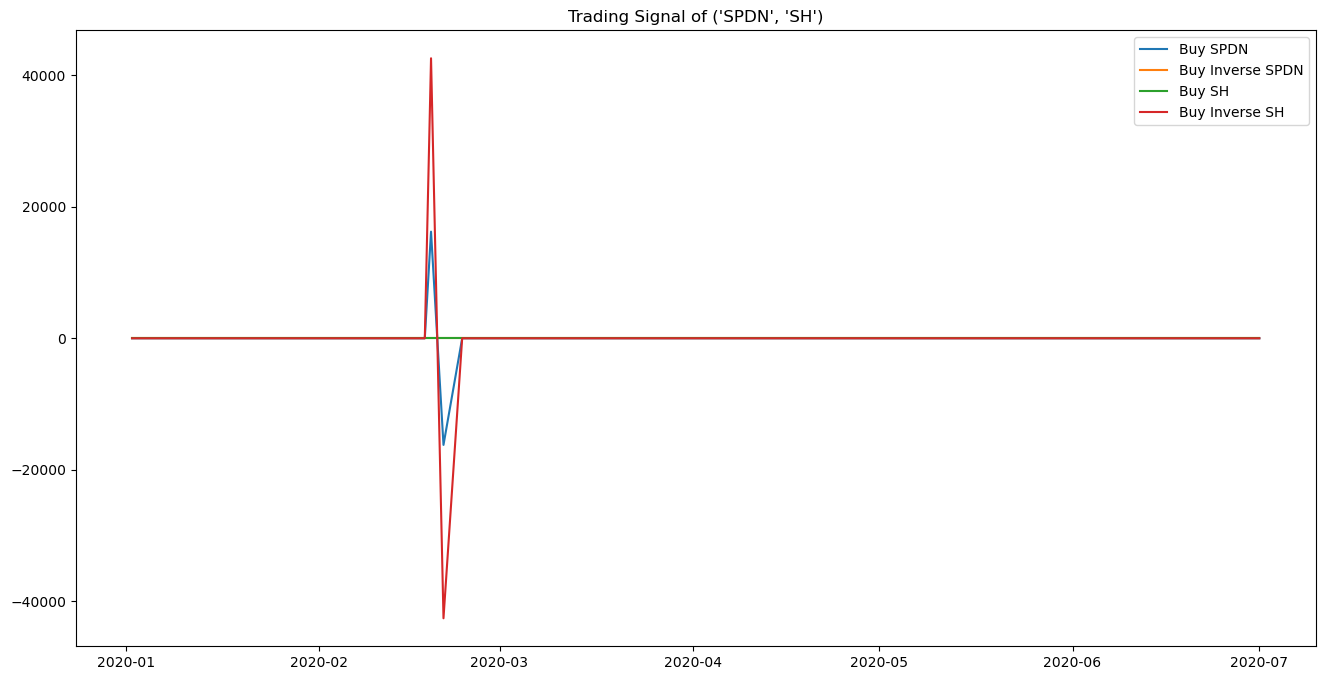

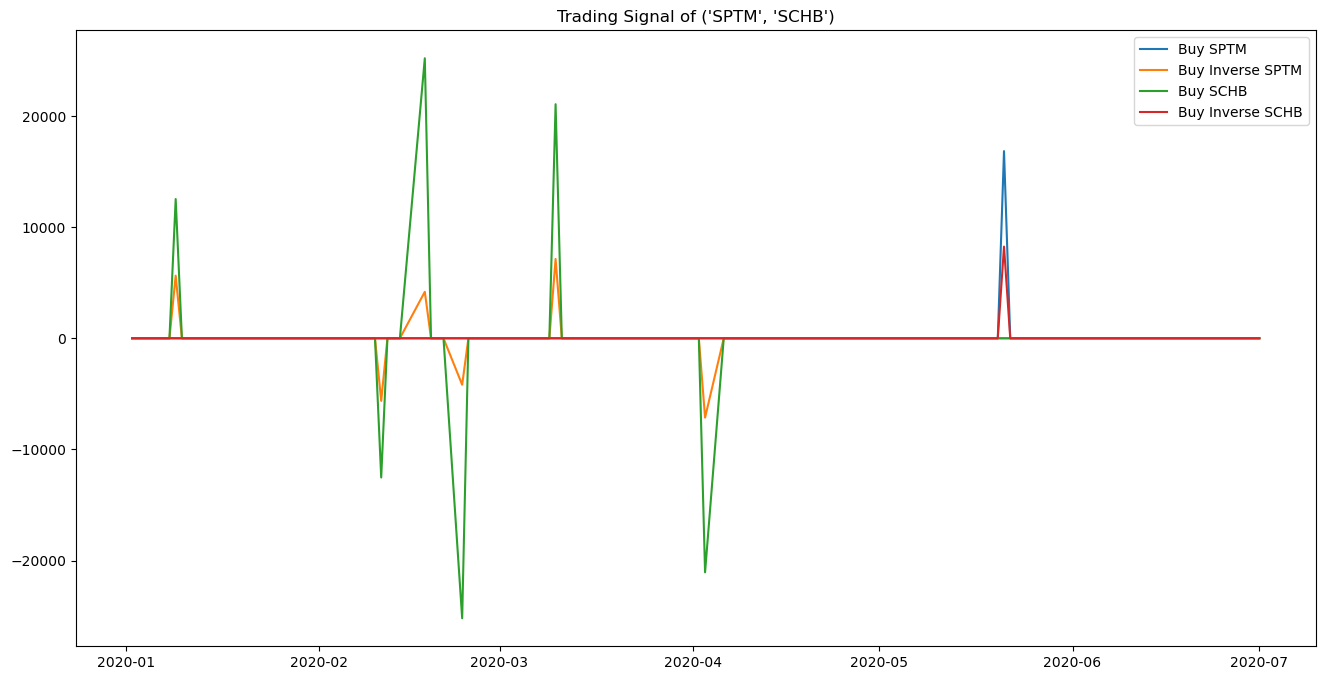

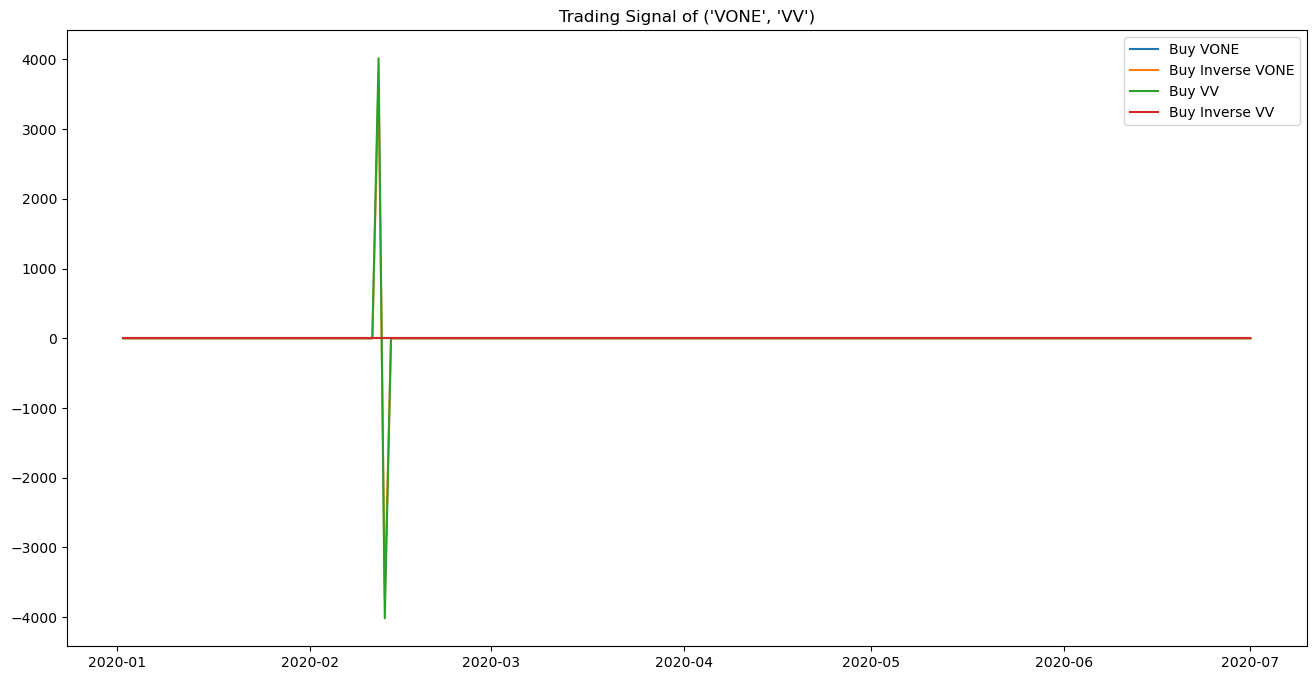

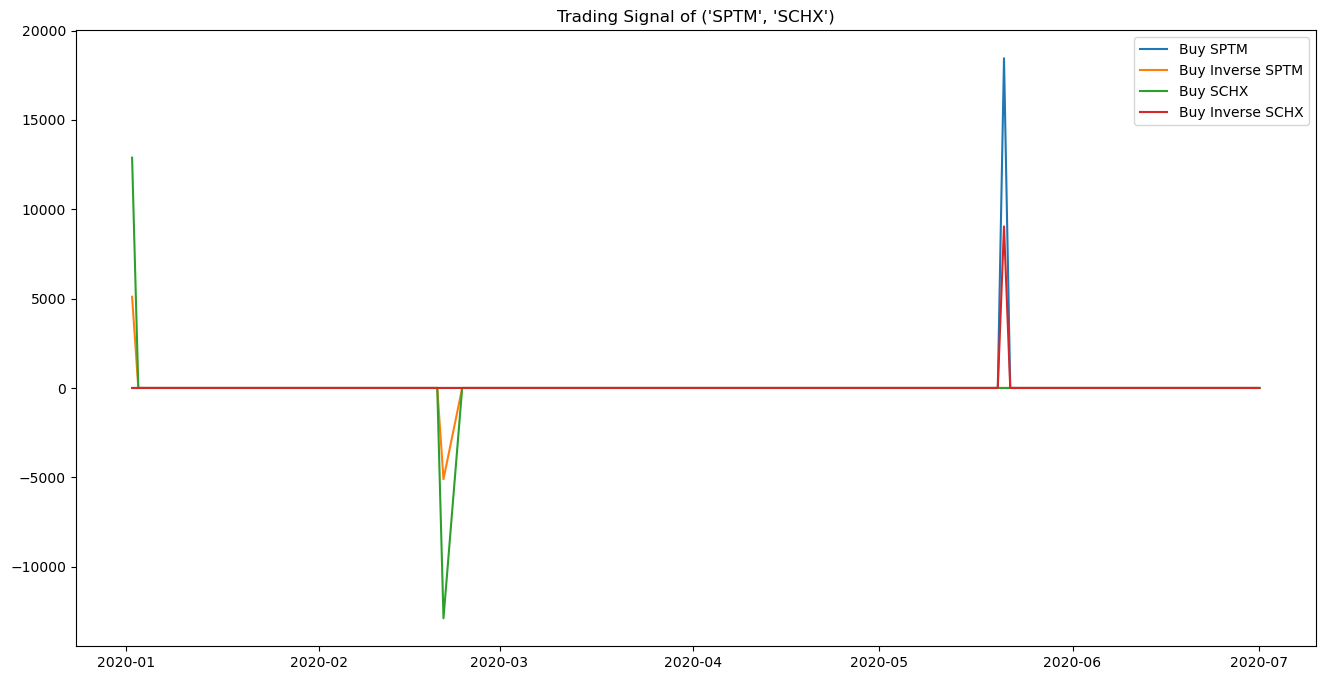

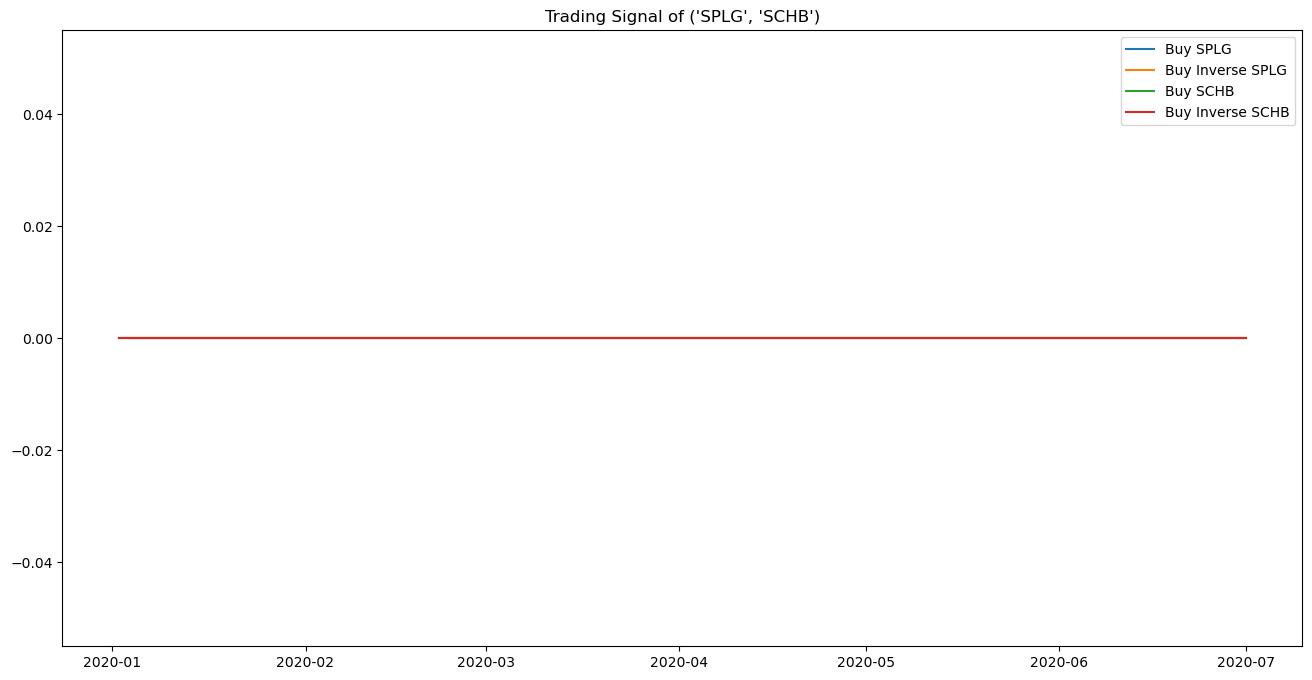

In [35]:
trial = 14

trial_df = pd.DataFrame(result[f'trial_{trial}'])

result_index =  price_df.loc[trade_index(trial)[0]:trade_index(trial)[1]].index.unique()[:trial_df.iloc[0,0].size]

for name in trial_df.columns:
    signal = trial_df[name][3]
    plt.figure(figsize=(16,8))
    plt.title(f'Trading Signal of {name}')

    for x in range(len(signal)):
        tag = [f'Buy {name[0]}', f'Buy Inverse {name[0]}', f'Buy {name[1]}', f'Buy Inverse {name[1]}']
        plt.plot(result_index, signal[x], label=tag[x])
        
    plt.legend()
    plt.show()
    

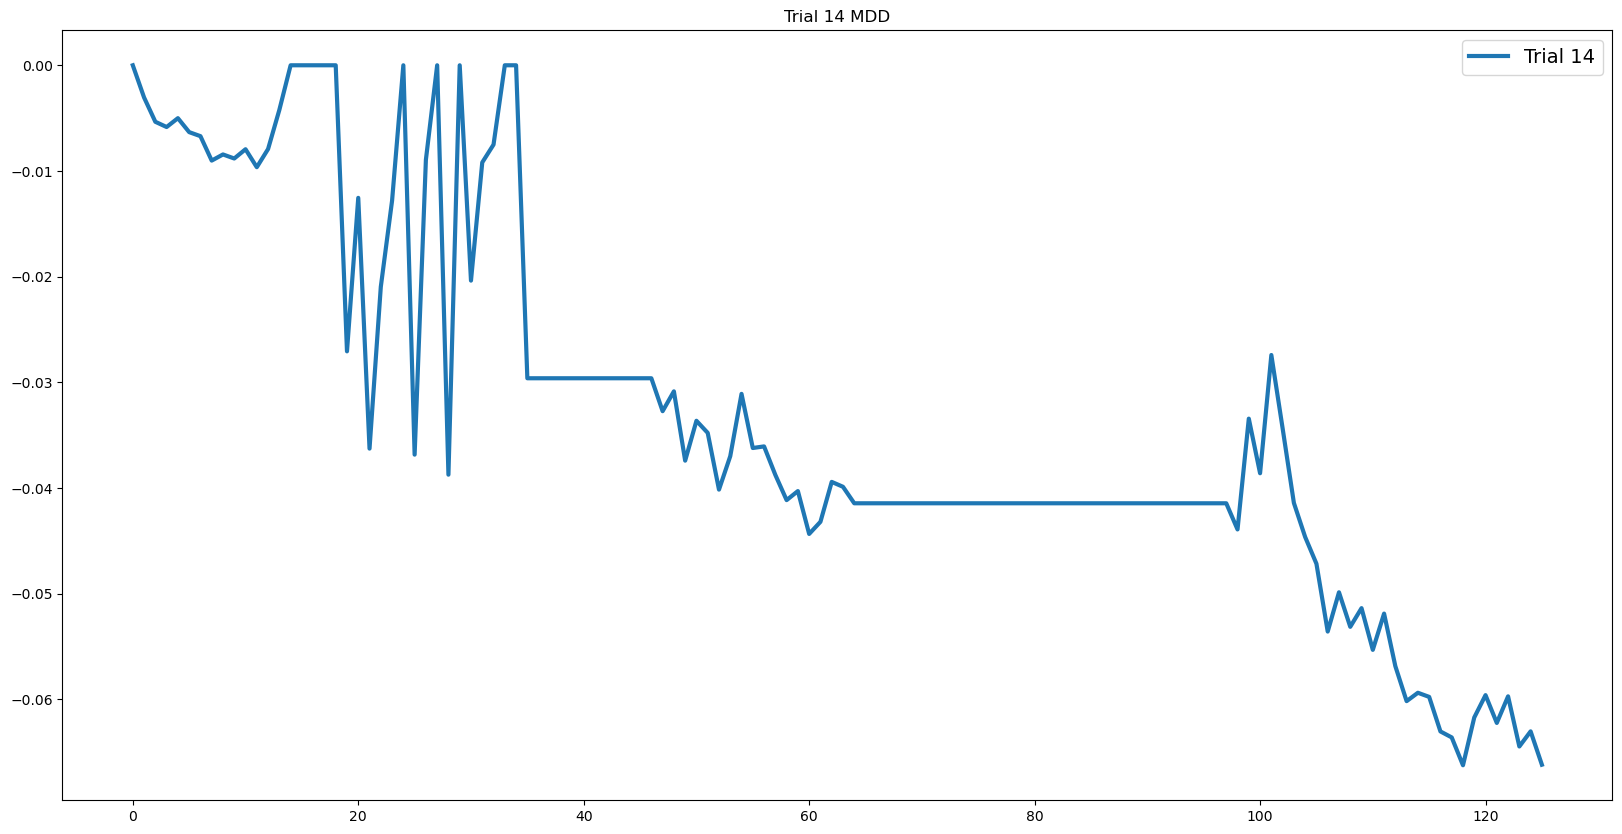

In [38]:
plt.figure(figsize=(20,10))
plt.title('Trial 14 MDD')
for x in range(14, 15):
    try:
        plt.plot(mdd(result, price_df, x, 2)[1], linewidth=3, label=f'Trial {x}')
    except:
        pass
plt.legend(fontsize=14)
plt.show()

In [ ]:
#(asset_per_pair_dic, total_asset_dic, threshold_dic, trading_vol_dic, transaction_cost_dic)

In [ ]:
pair_name = []

list(result['trial_2'][0].keys())[0]

('SPTM', 'SCHB')

In [ ]:
for x in range(len(result['trial_2'])):
    print(result['trial_2'][x])

KeyError: 0

In [ ]:
trial_df[trial_columns[0]][0].shape

(1, 125)